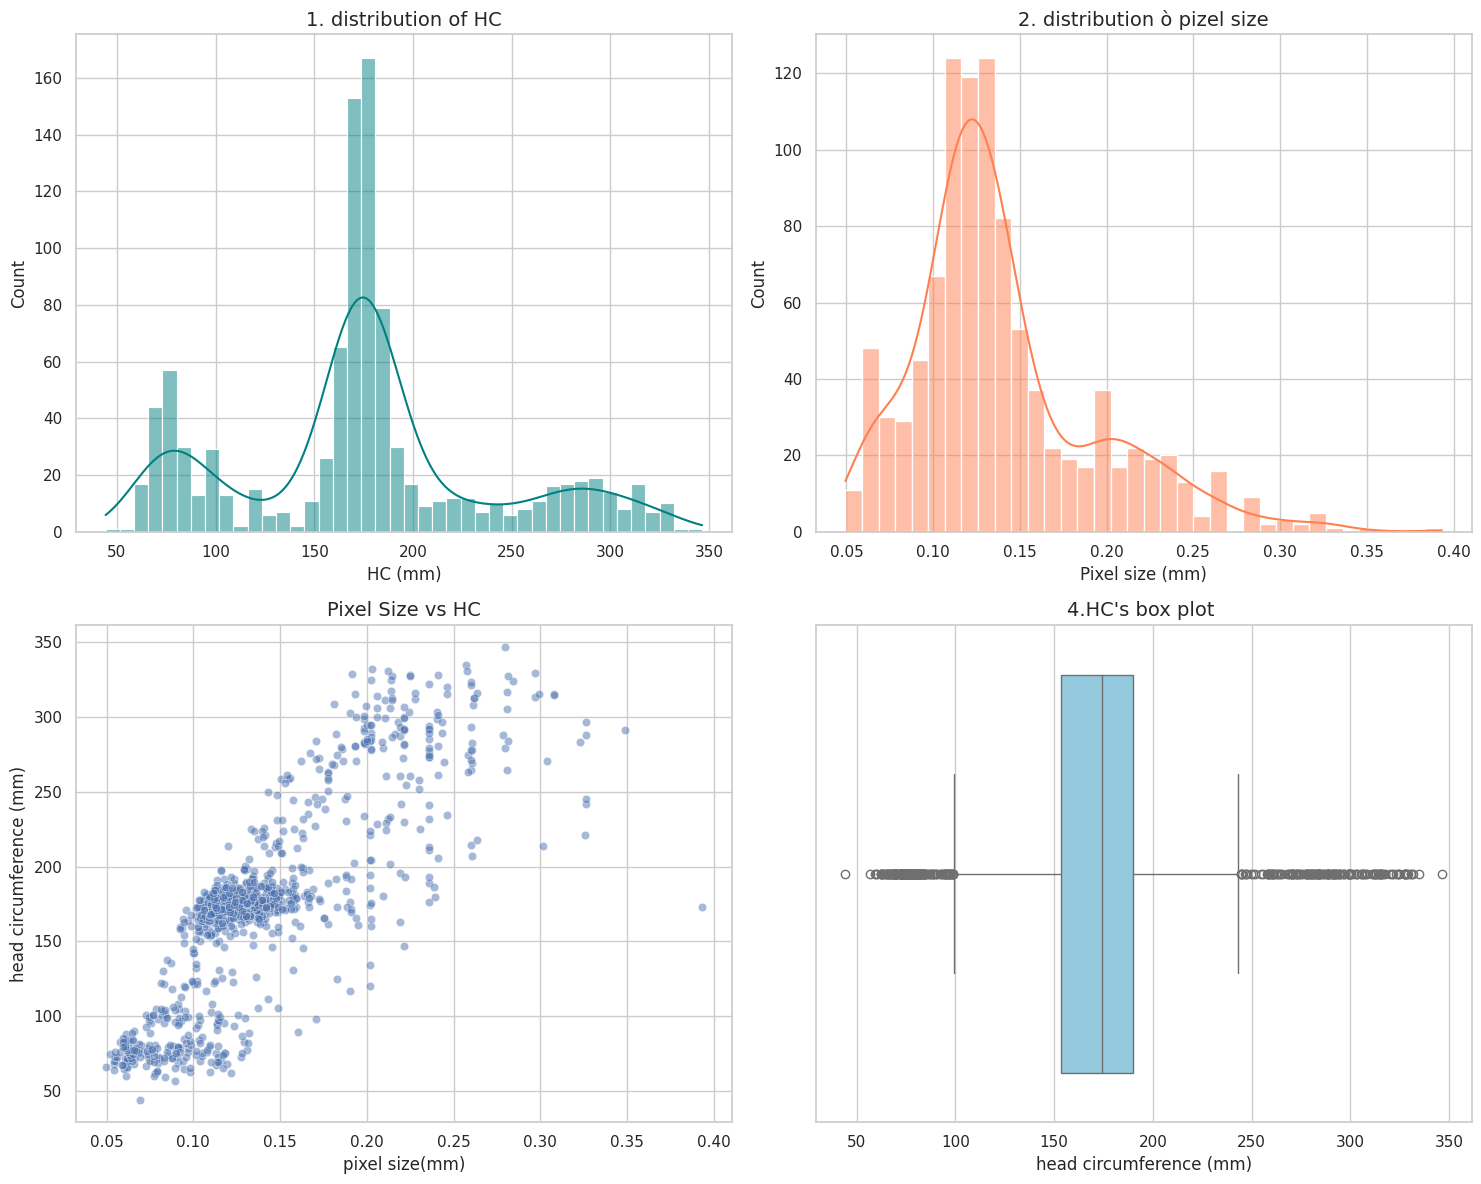

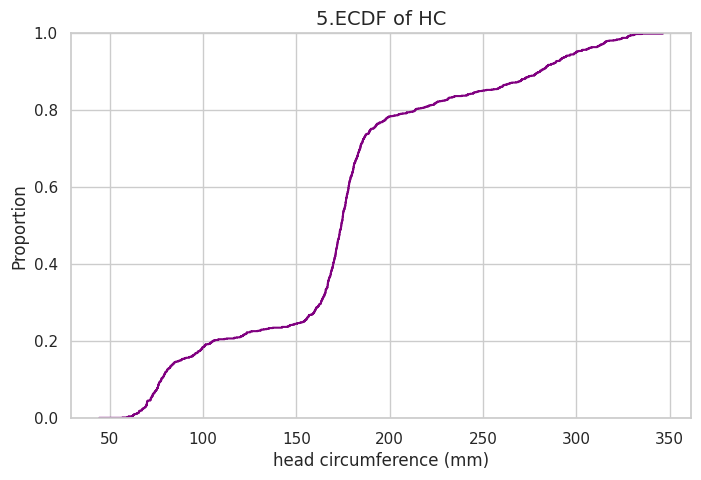

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load
df = pd.read_csv('/kaggle/input/hc18mlmed-2026/training_set_pixel_size_and_HC.csv')

sns.set_theme(style="whitegrid")

# 4 plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#1
sns.histplot(df['head circumference (mm)'], kde=True, ax=axes[0, 0], color='teal')
axes[0, 0].set_title('1. distribution of HC', fontsize=14)
axes[0, 0].set_xlabel('HC (mm)')

#2
sns.histplot(df['pixel size(mm)'], kde=True, ax=axes[0, 1], color='coral')
axes[0, 1].set_title('2. distribution ò pizel size', fontsize=14)
axes[0, 1].set_xlabel('Pixel size (mm)')

#3
sns.scatterplot(data=df, x='pixel size(mm)', y='head circumference (mm)', alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Pixel Size vs HC', fontsize=14)

#4
sns.boxplot(x=df['head circumference (mm)'], ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title("4.HC's box plot ", fontsize=14)

plt.tight_layout()
plt.show()

#5
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=df, x='head circumference (mm)', color='purple')
plt.title('5.ECDF of HC', fontsize=14)
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#CONFIG
IMG_DIR = '/kaggle/input/hc18mlmed-2026/training_set/training_set'
CSV_PATH = '/kaggle/input/hc18mlmed-2026/training_set_pixel_size_and_HC.csv'
BATCH_SIZE = 32        # Giảm xuống 32 để an toàn cho GPU khi thêm nhánh mới
NUM_WORKERS = 2
EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class HC18Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        
        image = Image.open(img_path).convert('RGB')
        
        pixel_size = torch.tensor([row['pixel size(mm)']], dtype=torch.float32)
        
        label = torch.tensor([row['head circumference (mm)']], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
            
        return image, pixel_size, label

#FUSION
class MedicalResNet(nn.Module):
    def __init__(self):
        super(MedicalResNet, self).__init__()
        #ResNet34
        self.resnet = models.resnet34(pretrained=True)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        self.meta_fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU()
        )
        
        self.final_fc = nn.Sequential(
            nn.Linear(512 + 16, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1) 
        )

    def forward(self, img, pixel_size):

        x_img = self.features(img)
        x_img = torch.flatten(x_img, 1) 
        
        x_meta = self.meta_fc(pixel_size)
        
        combined = torch.cat((x_img, x_meta), dim=1)
        
        out = self.final_fc(combined)
        return out

#PREPARE DATA
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

df = pd.read_csv(CSV_PATH)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_loader = DataLoader(HC18Dataset(train_df, IMG_DIR, train_transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=0,persistent_workers=False)
val_loader = DataLoader(HC18Dataset(val_df, IMG_DIR, val_transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=0,persistent_workers=False)

#SETUP TRAINING
model = MedicalResNet().to(DEVICE)
criterion = nn.L1Loss() # MAE Loss
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

#TRAINING LOOP
def train():
    best_val_mae = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    print(f"Bắt đầu train với Feature Fusion trên {DEVICE}...")
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for images, pixel_sizes, labels in loop:
            images, pixel_sizes, labels = images.to(DEVICE), pixel_sizes.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()

            outputs = model(images, pixel_sizes)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_mae = 0
        with torch.no_grad():
            for images, pixel_sizes, labels in val_loader:
                images, pixel_sizes, labels = images.to(DEVICE), pixel_sizes.to(DEVICE), labels.to(DEVICE)
                outputs = model(images, pixel_sizes)
                val_mae += criterion(outputs, labels).item()
        
        avg_val_mae = val_mae / len(val_loader)
        history['val_loss'].append(avg_val_mae)
        
        scheduler.step(avg_val_mae)
        
        print(f"Epoch {epoch+1} -> Train MAE: {avg_train_loss:.2f} mm | Val MAE: {avg_val_mae:.2f} mm")
        
        if avg_val_mae < best_val_mae:
            best_val_mae = avg_val_mae
            torch.save(model.state_dict(), 'best_fusion_model.pth')
            print("--> Saved Best Model!")

    return history

#PLOT
def plot_results(history):
    plt.figure(figsize=(10,5))
    plt.plot(history['train_loss'], label='Train MAE')
    plt.plot(history['val_loss'], label='Val MAE')
    plt.title('Training Process with Pixel Size Fusion')
    plt.xlabel('Epochs')
    plt.ylabel('MAE (mm)')
    plt.legend()
    plt.grid(True)
    plt.savefig('fusion_result.png')
    plt.show()

"""# --- 8. RUN ---
if __name__ == "__main__":
    hist = train()
    plot_results(hist)"""

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 182MB/s]


'# --- 8. RUN ---\nif __name__ == "__main__":\n    hist = train()\n    plot_results(hist)'

In [3]:
def evaluate_and_plot_regression(model, val_loader, device):
    """
    Hàm đánh giá và vẽ biểu đồ Scatter + Residual
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    print("Đang tổng hợp kết quả dự đoán trên tập Validation...")
    
    with torch.no_grad():
        # Lấy cả 3 giá trị từ loader
        for images, pixel_sizes, labels in val_loader:
            images = images.to(device)
            pixel_sizes = pixel_sizes.to(device)
            labels = labels.to(device)
            
            # Truyền cả 2 đầu vào cho mô hình
            outputs = model(images, pixel_sizes)
            
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(labels.cpu().numpy().flatten())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Tính các chỉ số
    mae = np.mean(np.abs(all_preds - all_targets))
    correlation = np.corrcoef(all_preds, all_targets)[0, 1]
    
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 6))
    
    # 1. Scatter Plot: Predicted vs Actual
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=all_targets, y=all_preds, alpha=0.6, color='blue')
    # Vẽ đường chéo lý tưởng y=x
    min_val = min(all_targets.min(), all_preds.min())
    max_val = max(all_targets.max(), all_preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    plt.title(f'Dự đoán vs Thực tế (Corr: {correlation:.4f})', fontsize=14)
    plt.xlabel('Thực tế (mm)')
    plt.ylabel('Dự đoán (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Residual Plot: Phân phối sai số
    plt.subplot(1, 2, 2)
    residuals = all_preds - all_targets
    sns.histplot(residuals, kde=True, color='purple', bins=30)
    plt.axvline(0, color='red', linestyle='--', lw=2)
    plt.title(f'Phân phối sai số (Mean Error: {np.mean(residuals):.2f}mm)', fontsize=14)
    plt.xlabel('Lỗi (Dự đoán - Thực tế)')
    plt.ylabel('Số lượng mẫu')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('final_regression_analysis.png')
    plt.show()
    
    print(f"\n--- KẾT QUẢ ĐÁNH GIÁ ---")
    print(f"MAE trung bình: {mae:.2f} mm")
    print(f"Hệ số tương quan (Correlation): {correlation:.4f}")


def visualize_predictions(model, dataset, device, num_samples=4):
    """
    Hàm hiển thị ngẫu nhiên 4 ảnh kèm kết quả dự đoán
    """
    model.eval()
    plt.figure(figsize=(16, 5))
    
    # Chọn ngẫu nhiên index
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Lấy dữ liệu từ dataset (trả về 3 thứ)
        image, pixel_size, label = dataset[idx]
        
        # Thêm batch dimension (unsqueeze) để đưa vào mô hình
        image_input = image.unsqueeze(0).to(device)       # shape: (1, 3, 224, 224)
        pixel_input = pixel_size.unsqueeze(0).to(device)  # shape: (1, 1)
        
        with torch.no_grad():
            # Truyền 2 đầu vào
            pred = model(image_input, pixel_input).item()
            
        # Xử lý ảnh để hiển thị (Un-normalize)
        img_show = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_show = std * img_show + mean
        img_show = np.clip(img_show, 0, 1)
        
        # Vẽ
        ax = plt.subplot(1, num_samples, i+1)
        plt.imshow(img_show)
        
        # Đổi màu chữ: Xanh nếu sai số < 5mm, Đỏ nếu > 5mm
        error = abs(pred - label.item())
        color = 'green' if error < 5 else 'red'
        
        plt.title(f"Thực: {label.item():.1f}mm\nĐoán: {pred:.1f}mm\nLệch: {error:.1f}mm", 
                  color=color, fontsize=12, fontweight='bold')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

In [4]:
if __name__ == "__main__":
    history = train() 

Bắt đầu train với Feature Fusion trên cuda...


Epoch 1/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 -> Train MAE: 171.05 mm | Val MAE: 168.08 mm
--> Saved Best Model!


Epoch 2/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 -> Train MAE: 163.78 mm | Val MAE: 156.94 mm
--> Saved Best Model!


Epoch 3/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 -> Train MAE: 151.97 mm | Val MAE: 144.12 mm
--> Saved Best Model!


Epoch 4/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 -> Train MAE: 136.61 mm | Val MAE: 128.56 mm
--> Saved Best Model!


Epoch 5/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 -> Train MAE: 118.63 mm | Val MAE: 108.77 mm
--> Saved Best Model!


Epoch 6/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 -> Train MAE: 99.29 mm | Val MAE: 60.44 mm
--> Saved Best Model!


Epoch 7/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 -> Train MAE: 78.69 mm | Val MAE: 54.73 mm
--> Saved Best Model!


Epoch 8/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 -> Train MAE: 55.40 mm | Val MAE: 26.27 mm
--> Saved Best Model!


Epoch 9/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 -> Train MAE: 34.81 mm | Val MAE: 27.01 mm


Epoch 10/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 -> Train MAE: 23.54 mm | Val MAE: 21.04 mm
--> Saved Best Model!


Epoch 11/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 -> Train MAE: 18.82 mm | Val MAE: 53.66 mm


Epoch 12/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 -> Train MAE: 19.90 mm | Val MAE: 31.13 mm


Epoch 13/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 -> Train MAE: 18.34 mm | Val MAE: 12.26 mm
--> Saved Best Model!


Epoch 14/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 -> Train MAE: 15.59 mm | Val MAE: 16.92 mm


Epoch 15/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 -> Train MAE: 15.17 mm | Val MAE: 14.06 mm


Epoch 16/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 -> Train MAE: 14.53 mm | Val MAE: 12.83 mm


Epoch 17/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 -> Train MAE: 14.68 mm | Val MAE: 14.28 mm


Epoch 18/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 -> Train MAE: 15.34 mm | Val MAE: 10.21 mm
--> Saved Best Model!


Epoch 19/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 -> Train MAE: 14.16 mm | Val MAE: 15.33 mm


Epoch 20/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 -> Train MAE: 14.40 mm | Val MAE: 10.97 mm


Epoch 21/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21 -> Train MAE: 13.86 mm | Val MAE: 13.15 mm


Epoch 22/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22 -> Train MAE: 15.20 mm | Val MAE: 12.24 mm


Epoch 23/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23 -> Train MAE: 14.12 mm | Val MAE: 11.90 mm


Epoch 24/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24 -> Train MAE: 13.00 mm | Val MAE: 9.65 mm
--> Saved Best Model!


Epoch 25/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25 -> Train MAE: 13.24 mm | Val MAE: 11.80 mm


Epoch 26/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26 -> Train MAE: 13.19 mm | Val MAE: 12.92 mm


Epoch 27/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27 -> Train MAE: 14.20 mm | Val MAE: 15.41 mm


Epoch 28/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28 -> Train MAE: 13.85 mm | Val MAE: 13.14 mm


Epoch 29/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29 -> Train MAE: 13.77 mm | Val MAE: 10.72 mm


Epoch 30/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30 -> Train MAE: 14.23 mm | Val MAE: 11.48 mm


Epoch 31/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 31 -> Train MAE: 12.24 mm | Val MAE: 11.03 mm


Epoch 32/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 32 -> Train MAE: 12.45 mm | Val MAE: 11.29 mm


Epoch 33/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 33 -> Train MAE: 12.21 mm | Val MAE: 9.21 mm
--> Saved Best Model!


Epoch 34/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 34 -> Train MAE: 12.21 mm | Val MAE: 9.67 mm


Epoch 35/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 35 -> Train MAE: 13.33 mm | Val MAE: 9.37 mm


Epoch 36/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 36 -> Train MAE: 12.69 mm | Val MAE: 10.51 mm


Epoch 37/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 37 -> Train MAE: 12.06 mm | Val MAE: 13.64 mm


Epoch 38/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 38 -> Train MAE: 12.31 mm | Val MAE: 10.67 mm


Epoch 39/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 39 -> Train MAE: 12.47 mm | Val MAE: 8.79 mm
--> Saved Best Model!


Epoch 40/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 40 -> Train MAE: 11.49 mm | Val MAE: 9.71 mm


Epoch 41/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 41 -> Train MAE: 11.82 mm | Val MAE: 10.43 mm


Epoch 42/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 42 -> Train MAE: 12.28 mm | Val MAE: 14.26 mm


Epoch 43/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 43 -> Train MAE: 13.11 mm | Val MAE: 12.61 mm


Epoch 44/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 44 -> Train MAE: 11.88 mm | Val MAE: 11.26 mm


Epoch 45/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 45 -> Train MAE: 12.57 mm | Val MAE: 11.46 mm


Epoch 46/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 46 -> Train MAE: 11.33 mm | Val MAE: 9.86 mm


Epoch 47/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 47 -> Train MAE: 12.74 mm | Val MAE: 9.23 mm


Epoch 48/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 48 -> Train MAE: 13.04 mm | Val MAE: 9.16 mm


Epoch 49/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 49 -> Train MAE: 11.47 mm | Val MAE: 9.90 mm


Epoch 50/50:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 50 -> Train MAE: 11.26 mm | Val MAE: 9.04 mm


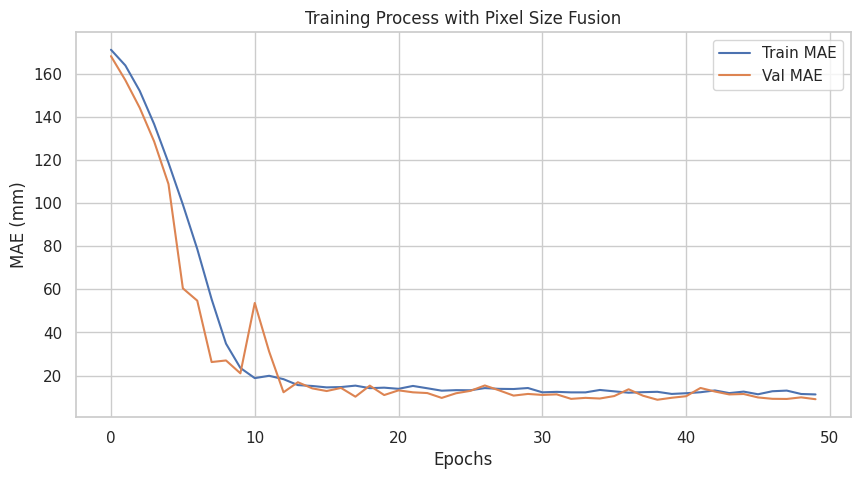

load_best_model...
Đang tổng hợp kết quả dự đoán trên tập Validation...


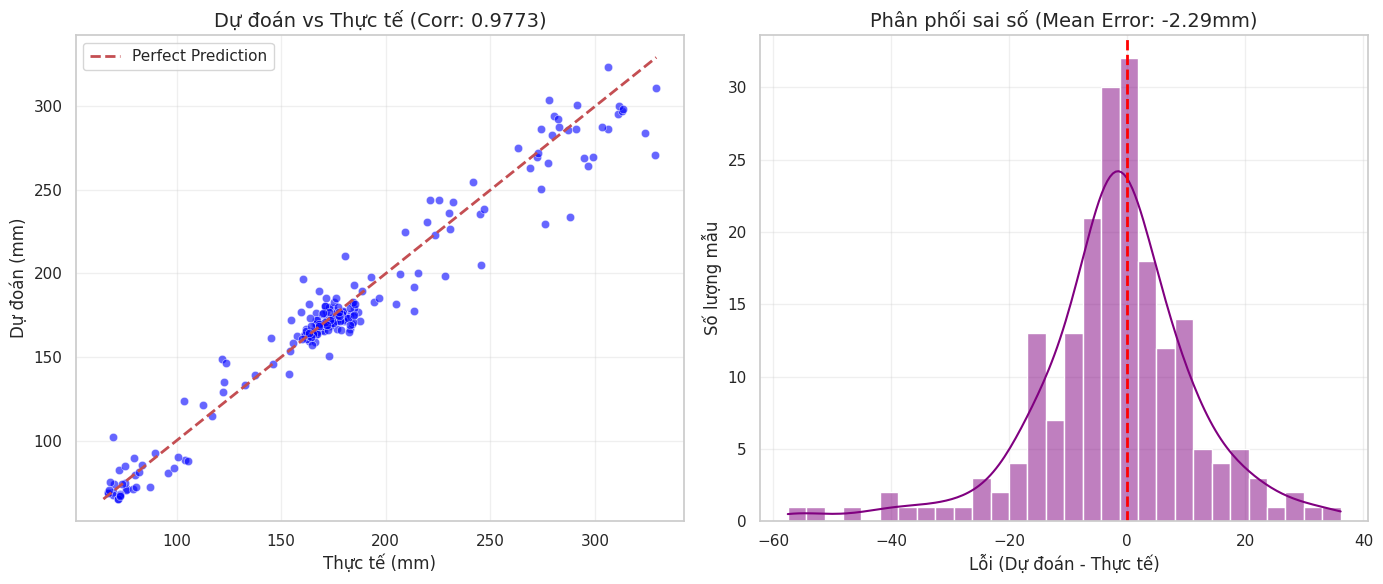


--- KẾT QUẢ ĐÁNH GIÁ ---
MAE trung bình: 9.48 mm
Hệ số tương quan (Correlation): 0.9773


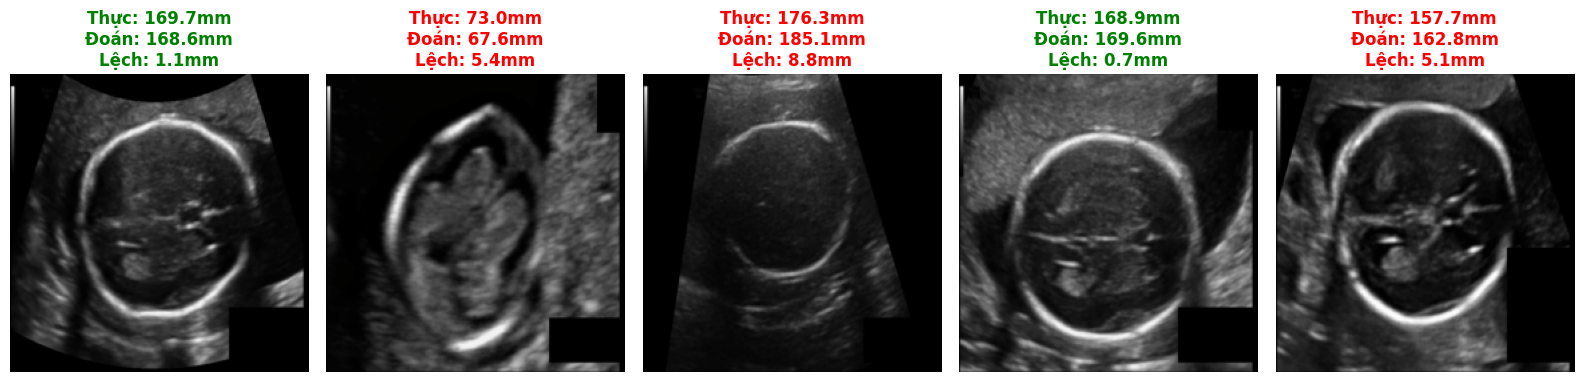

In [5]:
plot_results(history)
    
print("load_best_model...")
model.load_state_dict(torch.load('best_fusion_model.pth'))
    
evaluate_and_plot_regression(model, val_loader, DEVICE)
    
val_dataset_viz = HC18Dataset(val_df, IMG_DIR, val_transform)
visualize_predictions(model, val_dataset_viz, DEVICE, num_samples=5)